In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===== MIF Module =====
class MIFModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv288 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv144 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv72 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv36 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x288 = x
        x144 = F.interpolate(x, size=(144, 144), mode='bilinear', align_corners=True)
        x72 = F.interpolate(x, size=(72, 72), mode='bilinear', align_corners=True)
        x36 = F.interpolate(x, size=(36, 36), mode='bilinear', align_corners=True)

        s288 = self.conv288(x288)
        s144 = self.conv144(x144)
        s72 = self.conv72(x72)
        s36 = self.conv36(x36)

        return s288, s144, s72, s36
# ===== Res2Block + SEBlock =====
class Res2Block(nn.Module):
    def __init__(self, in_channels, out_channels, scale=4):
        super().__init__()
        assert in_channels % scale == 0
        self.scale = scale
        self.width = in_channels // scale

        self.conv1x1_in = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.width, self.width, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(self.width),
                nn.ReLU(inplace=True)
            ) for _ in range(scale - 1)
        ])

        self.conv1x1_out = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn_out = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1x1_in(x)
        splits = torch.split(out, self.width, dim=1)
        outputs = [splits[0]]

        for i in range(1, self.scale):
            if i == 1:
                y = self.convs[i - 1](splits[i])
            else:
                y = self.convs[i - 1](splits[i] + outputs[-1])
            outputs.append(y)

        out = torch.cat(outputs, dim=1)
        out = self.conv1x1_out(out)
        out = self.bn_out(out)
        out += identity
        return self.relu(out)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class Res2SEBlock(nn.Module):
    def __init__(self, channels, dropout=0.3):
        super().__init__()
        self.res2 = Res2Block(channels, channels)
        self.se = SEBlock(channels)
        self.dropout = nn.Dropout2d(dropout)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.res2(x)
        out = self.se(out)
        out = self.dropout(out)
        out = self.bn(out)
        out = self.relu(out)
        return out + identity
# ===== PDC Block =====
class PDCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch2_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch2_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch3_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch3_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.branch4_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=8, dilation=8),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True)
        )
        self.branch4_conv4 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.fuse = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)

        b2 = self.branch2_conv2(self.branch2_conv1(x))

        b3_1 = self.branch3_conv1(x)
        b3_2 = self.branch3_conv2(b3_1)
        b3 = self.branch3_conv3(b3_1 + b3_2)

        b4_1 = self.branch4_conv1(x)
        b4_2 = self.branch4_conv2(b4_1)
        b4_3 = self.branch4_conv3(b4_2 + b4_1)
        b4 = self.branch4_conv4(b4_3 + b4_2 + b4_1)

        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.fuse(out)
# ===== Final MRP_UNet Model =====
class MRP_UNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.mif = MIFModule()

        # Main encoder
        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)

        # Side encoders (for MIF features)
        self.side_enc2 = Res2SEBlock(64)
        self.side_enc3 = Res2SEBlock(128)
        self.side_enc4 = Res2SEBlock(256)

        # Bottleneck
        self.bottleneck_pre = Res2SEBlock(512)
        self.pdc = PDCBlock(512, 512)
        self.bottleneck_post = Res2SEBlock(512)

        # Decoder
        self.dec4 = self.decoder_block(1024, 512, 256)
        self.dec3 = self.decoder_block(512, 256, 128)
        self.dec2 = self.decoder_block(256, 128, 64)
        self.dec1 = self.decoder_block(128, 64, 64)

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def decoder_block(self, in_ch, mid_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):  # [B, 3, 288, 288]
        s288, s144, s72, s36 = self.mif(x)

        # Encoder
        e1 = self.enc1(s288)
        skip1 = e1
        x = F.max_pool2d(e1, 2)

        s144 = self.side_enc2(s144)
        x = torch.cat([x, s144], dim=1)
        e2 = self.enc2(x)
        skip2 = e2
        x = F.max_pool2d(e2, 2)

        s72 = self.side_enc3(s72)
        x = torch.cat([x, s72], dim=1)
        e3 = self.enc3(x)
        skip3 = e3
        x = F.max_pool2d(e3, 2)

        s36 = self.side_enc4(s36)
        x = torch.cat([x, s36], dim=1)
        e4 = self.enc4(x)
        skip4 = e4
        x = F.max_pool2d(e4, 2)

        # Bottleneck
        x = self.bottleneck_pre(x)
        x = self.pdc(x)
        x = self.bottleneck_post(x)

        # Decoder
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip4], dim=1)
        x = self.dec4(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip3], dim=1)
        x = self.dec3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], dim=1)
        x = self.dec2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], dim=1)
        x = self.dec1(x)

        return self.final(x)  # [B, num_classes, 288, 288]


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Create output folder
os.makedirs("fine_masks", exist_ok=True)

# Image and mask directories
img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
model_path = "/kaggle/input/best_model/pytorch/default/1/best_model(7).pth"


In [ ]:
class ISICDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_names = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.transform = transform or transforms.Compose([
            transforms.Resize((288, 288)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        return self.transform(img), img_name

    def __len__(self):
        return len(self.image_names)
dataset = ISICDataset(img_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
model = MRP_UNet(num_classes=2)
state_dict = torch.load(model_path, map_location='cuda')
model.load_state_dict(state_dict)
model.eval().cuda()


MRP_UNet(
  (mif): MIFModule(
    (conv288): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv144): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv72): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv36): Sequential(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (enc1): Res2SEBlock(
    (res2): Res2Block(
      (conv1x1_in): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv1x1_out): Conv2d(64, 64, kernel_size=

100%|██████████| 2000/2000 [00:03<00:00, 629.24it/s]


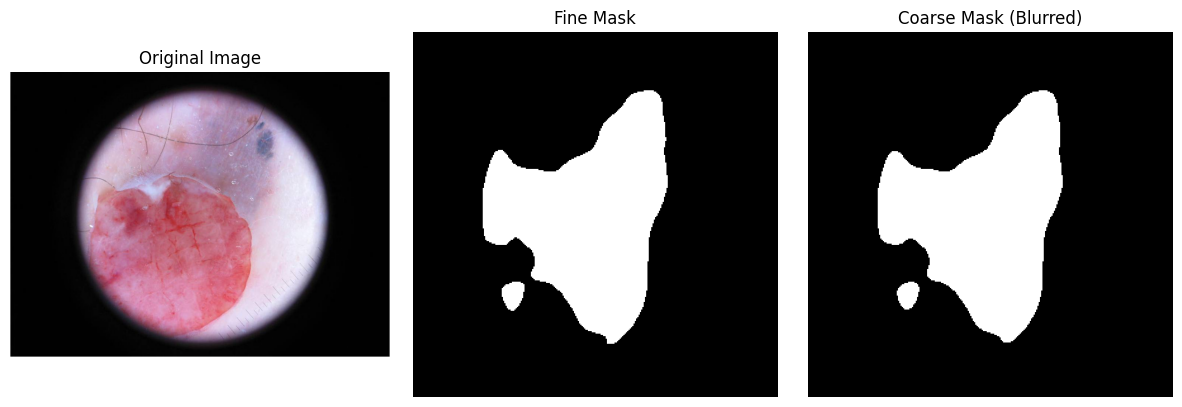

In [ ]:
def save_mask(tensor, path):
    """Save binary mask (1-channel) as PNG"""
    mask = (tensor.squeeze().cpu().numpy() * 255).astype(np.uint8)
    Image.fromarray(mask).save(path)

with torch.no_grad():
    for imgs, names in tqdm(dataloader):
        imgs = imgs.cuda()
        logits = model(imgs)               # [B, 2, H, W]
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)  # [B, H, W]

        for pred, name in zip(preds, names):
            out_path = f"fine_masks/{name.replace('.jpg', '.png')}"
            save_mask(pred.float(), out_path)
import cv2
import os
from tqdm import tqdm

input_dir = "fine_masks"
output_dir = "coarse_masks"
os.makedirs(output_dir, exist_ok=True)

def blur_and_binarize(input_path, output_path, kernel_size=15, threshold=127):
    """
    Applies Gaussian blur to a binary mask and saves the binarized result.
    """
    mask = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Failed to read {input_path}")
        return

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(mask, (kernel_size, kernel_size), 0)

    # Binarize: threshold to remove soft edges
    _, binary_mask = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)

    cv2.imwrite(output_path, binary_mask)

# Apply to all fine masks
for fname in tqdm(os.listdir(input_dir)):
    if not fname.endswith(".png"):
        continue
    in_path = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)
    blur_and_binarize(in_path, out_path)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Directories
img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
fine_dir = "fine_masks"
coarse_dir = "coarse_masks"

# Get a few sample filenames (change as needed)
sample_files = sorted([f for f in os.listdir(fine_dir) if f.endswith(".png")])[:5]

for fname in sample_files:
    # Load image and masks
    img_path = os.path.join(img_dir, fname.replace(".png", ".jpg"))
    fine_path = os.path.join(fine_dir, fname)
    coarse_path = os.path.join(coarse_dir, fname)

    # Load using PIL for RGB, OpenCV for masks
    image = np.array(Image.open(img_path).convert("RGB"))
    fine_mask = cv2.imread(fine_path, cv2.IMREAD_GRAYSCALE)
    coarse_mask = cv2.imread(coarse_path, cv2.IMREAD_GRAYSCALE)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(fine_mask, cmap="gray")
    plt.title("Fine Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(coarse_mask, cmap="gray")
    plt.title("Coarse Mask (Blurred)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("/kaggle/input/isic-2017/ISIC-2017_Training_Part3_GroundTruth.csv")

# Add 'filename' column
df["filename"] = df["image_id"] + ".jpg"

# Compute third class: nevus = 1 - MEL - SK
df["nevus"] = 1.0 - df["melanoma"] - df["seborrheic_keratosis"]

# Find dominant class
df["label"] = df[["melanoma", "nevus", "seborrheic_keratosis"]].idxmax(axis=1)

# Map class labels to numeric
class_map = {"melanoma": 0, "nevus": 1, "seborrheic_keratosis": 2}
df["label_idx"] = df["label"].map(class_map)

df.head()


,image_id,melanoma,seborrheic_keratosis,filename,nevus,label,label_idx
0,ISIC_0000000,0.0,0.0,ISIC_0000000.jpg,1.0,nevus,1
1,ISIC_0000001,0.0,0.0,ISIC_0000001.jpg,1.0,nevus,1
2,ISIC_0000002,1.0,0.0,ISIC_0000002.jpg,0.0,melanoma,0
3,ISIC_0000003,0.0,0.0,ISIC_0000003.jpg,1.0,nevus,1
4,ISIC_0000004,1.0,0.0,ISIC_0000004.jpg,0.0,melanoma,0


In [ ]:
image_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
coarse_mask_dir = "coarse_masks"


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

features_blobs = []

class MaskCN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskCN, self).__init__()
        self.backbone = timm.create_model("legacy_xception", pretrained=True, num_classes=0, features_only=False)

        # Modify first conv layer for 4 channels
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight
            self.backbone.conv1.weight[:, 3:] = old_conv.weight[:, :1]  # duplicate channel

        # Final classifier head
        self.classifier = nn.Linear(self.backbone.num_features, num_classes)

        # Register CAM hook from final block
        self.backbone.global_pool.register_forward_hook(self._hook_feature)

    def _hook_feature(self, module, input, output):
        features_blobs.clear()
        features_blobs.append(input[0])  # Input to GAP is [B,C,H,W]

    def forward(self, x):
        feats = self.backbone(x)  # [B, num_features]
        out = self.classifier(feats)
        return out

def generate_cam(model, input_tensor, class_idx=None):
    model.eval()
    features_blobs.clear()

    with torch.no_grad():
        logits = model(input_tensor.unsqueeze(0).to(next(model.parameters()).device))
        pred_idx = logits.argmax(dim=1).item() if class_idx is None else class_idx

    feature_map = features_blobs[0].squeeze(0)  # [C, H, W]
    weights = model.classifier.weight[pred_idx]  # [C]

    cam = torch.sum(weights[:, None, None] * feature_map, dim=0).detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    return cam

def show_cam(input_tensor, cam, figsize=(12, 4)):
    rgb = input_tensor[:3].permute(1, 2, 0).cpu().numpy()
    rgb = (rgb - rgb.min()) / (rgb.max() + 1e-8)

    cam_resized = cv2.resize(cam, (rgb.shape[1], rgb.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * 0.5 + rgb * 0.5

    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1); plt.imshow(rgb); plt.title("Input Image"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(cam_resized, cmap='jet'); plt.title("CAM"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.tight_layout()
    plt.show()
import os
from tqdm import tqdm
from torchvision.utils import save_image

def save_cams_for_dataset(model, dataset, save_dir, device='cuda'):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device).eval()
    print(f"Saving CAMs to: {save_dir}")

    for idx in tqdm(range(len(dataset))):
        img4, label = dataset[idx]  # [4, H, W], int
        filename = dataset.df.iloc[idx].filename.replace(".jpg", ".png")
        input_tensor = img4.to(device)

        cam = generate_cam(model, input_tensor, class_idx=label)
        cam_tensor = torch.tensor(cam).unsqueeze(0)  # [1, H, W]
        save_path = os.path.join(save_dir, filename)

        # Save as grayscale .png
        save_image(cam_tensor, save_path)


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import os

class MaskCNDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485]*4, std=[0.229]*4)
        ])
        self.resize = transforms.Resize((288, 288))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row.filename)
        mask_path = os.path.join(self.mask_dir, row.filename.replace(".jpg", ".png"))

        # Load image and mask, resize both to 288×288
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        img = self.resize(img)
        mask = self.resize(mask)

        # Convert to numpy
        img_np = np.array(img).astype("float32") / 255.0  # [H, W, 3]
        mask_np = np.array(mask).astype("float32") / 255.0  # [H, W]
        mask_np = np.expand_dims(mask_np, axis=-1)  # [H, W, 1]

        # Combine to 4-channel image
        img4_np = np.concatenate([img_np, mask_np], axis=-1)  # [H, W, 4]
        img4_pil = Image.fromarray((img4_np * 255).astype("uint8"))

        # Apply final transform (ToTensor + Normalize)
        img4_tensor = self.transform(img4_pil)

        label = row.label_idx
        return img4_tensor, label

    def __len__(self):
        return len(self.df)


In [ ]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torchvision import transforms

# Define 4-channel normalization transform
transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485]*4, std=[0.229]*4)
])

# Split dataframe
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label_idx"], random_state=42)

# Create datasets
train_dataset = MaskCNDataset(train_df, image_dir, coarse_mask_dir, transform=transform)
val_dataset   = MaskCNDataset(val_df, image_dir, coarse_mask_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskCN(num_classes=3).to(device)

# Compute class weights
class_counts = np.bincount(df["label_idx"])
total = sum(class_counts)
class_weights = total / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Weighted loss & optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from tqdm import tqdm

best_val_acc = 0.0

for epoch in range(20):
    model.train()
    train_loss, train_preds, train_labels = 0.0, [], []

    train_pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1:02d}] Training", leave=False)
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        train_pbar.set_postfix(loss=loss.item())

    train_acc = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    val_pbar = tqdm(val_loader, desc=f"[Epoch {epoch+1:02d}] Validation", leave=False)
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            val_pbar.set_postfix(loss=loss.item())

    val_acc = accuracy_score(val_labels, val_preds)

    print(f"\n [Epoch {epoch+1:02d}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(classification_report(val_labels, val_preds, target_names=class_map.keys()))


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mask_cn_best_val.pth")
        print(" Best model saved!")



 [Epoch 01] Train Loss: 47.1907 | Train Acc: 0.7881 | Val Loss: 18.7900 | Val Acc: 0.7575
                      precision    recall  f1-score   support

            melanoma       0.57      0.52      0.54        75
               nevus       0.85      0.84      0.84       274
seborrheic_keratosis       0.58      0.69      0.63        51

            accuracy                           0.76       400
           macro avg       0.66      0.68      0.67       400
        weighted avg       0.76      0.76      0.76       400

 Best model saved!



 [Epoch 02] Train Loss: 20.6398 | Train Acc: 0.9237 | Val Loss: 20.7298 | Val Acc: 0.7775
                      precision    recall  f1-score   support

            melanoma       0.62      0.53      0.58        75
               nevus       0.86      0.86      0.86       274
seborrheic_keratosis       0.57      0.71      0.63        51

            accuracy                           0.78       400
           macro avg       0.69      0.70      0.69       400
        weighted avg       0.78      0.78      0.78       400

 Best model saved!



 [Epoch 03] Train Loss: 9.4807 | Train Acc: 0.9719 | Val Loss: 22.1150 | Val Acc: 0.7600
                      precision    recall  f1-score   support

            melanoma       0.58      0.56      0.57        75
               nevus       0.89      0.81      0.85       274
seborrheic_keratosis       0.51      0.80      0.62        51

            accuracy                           0.76       400
           macro avg       0.66      0.72      0.68       400
        weighted avg       0.79      0.76      0.77       400




 [Epoch 04] Train Loss: 5.7651 | Train Acc: 0.9856 | Val Loss: 31.9938 | Val Acc: 0.7775
                      precision    recall  f1-score   support

            melanoma       0.55      0.43      0.48        75
               nevus       0.83      0.90      0.86       274
seborrheic_keratosis       0.73      0.63      0.67        51

            accuracy                           0.78       400
           macro avg       0.70      0.65      0.67       400
        weighted avg       0.76      0.78      0.77       400




 [Epoch 05] Train Loss: 3.7667 | Train Acc: 0.9888 | Val Loss: 26.0870 | Val Acc: 0.7975
                      precision    recall  f1-score   support

            melanoma       0.62      0.49      0.55        75
               nevus       0.85      0.89      0.87       274
seborrheic_keratosis       0.71      0.76      0.74        51

            accuracy                           0.80       400
           macro avg       0.73      0.71      0.72       400
        weighted avg       0.79      0.80      0.79       400

 Best model saved!



 [Epoch 06] Train Loss: 4.5205 | Train Acc: 0.9869 | Val Loss: 27.3124 | Val Acc: 0.7500
                      precision    recall  f1-score   support

            melanoma       0.49      0.67      0.56        75
               nevus       0.87      0.79      0.83       274
seborrheic_keratosis       0.69      0.67      0.68        51

            accuracy                           0.75       400
           macro avg       0.68      0.71      0.69       400
        weighted avg       0.77      0.75      0.76       400




 [Epoch 07] Train Loss: 6.4299 | Train Acc: 0.9775 | Val Loss: 30.7512 | Val Acc: 0.7775
                      precision    recall  f1-score   support

            melanoma       0.61      0.51      0.55        75
               nevus       0.84      0.87      0.85       274
seborrheic_keratosis       0.65      0.67      0.66        51

            accuracy                           0.78       400
           macro avg       0.70      0.68      0.69       400
        weighted avg       0.77      0.78      0.77       400




 [Epoch 08] Train Loss: 5.0412 | Train Acc: 0.9856 | Val Loss: 26.2519 | Val Acc: 0.7900
                      precision    recall  f1-score   support

            melanoma       0.59      0.55      0.57        75
               nevus       0.85      0.88      0.86       274
seborrheic_keratosis       0.70      0.69      0.69        51

            accuracy                           0.79       400
           macro avg       0.72      0.70      0.71       400
        weighted avg       0.79      0.79      0.79       400




 [Epoch 09] Train Loss: 5.2539 | Train Acc: 0.9862 | Val Loss: 26.2090 | Val Acc: 0.7425
                      precision    recall  f1-score   support

            melanoma       0.52      0.68      0.59        75
               nevus       0.89      0.78      0.83       274
seborrheic_keratosis       0.53      0.63      0.58        51

            accuracy                           0.74       400
           macro avg       0.65      0.70      0.66       400
        weighted avg       0.77      0.74      0.75       400




 [Epoch 10] Train Loss: 8.3699 | Train Acc: 0.9756 | Val Loss: 28.8023 | Val Acc: 0.7400
                      precision    recall  f1-score   support

            melanoma       0.60      0.48      0.53        75
               nevus       0.85      0.80      0.83       274
seborrheic_keratosis       0.49      0.78      0.61        51

            accuracy                           0.74       400
           macro avg       0.65      0.69      0.65       400
        weighted avg       0.76      0.74      0.74       400




 [Epoch 11] Train Loss: 2.0665 | Train Acc: 0.9956 | Val Loss: 36.4873 | Val Acc: 0.7775
                      precision    recall  f1-score   support

            melanoma       0.57      0.40      0.47        75
               nevus       0.81      0.91      0.86       274
seborrheic_keratosis       0.84      0.61      0.70        51

            accuracy                           0.78       400
           macro avg       0.74      0.64      0.68       400
        weighted avg       0.77      0.78      0.76       400




 [Epoch 12] Train Loss: 4.7023 | Train Acc: 0.9869 | Val Loss: 40.3286 | Val Acc: 0.7700
                      precision    recall  f1-score   support

            melanoma       0.60      0.40      0.48        75
               nevus       0.80      0.90      0.85       274
seborrheic_keratosis       0.76      0.61      0.67        51

            accuracy                           0.77       400
           macro avg       0.72      0.64      0.67       400
        weighted avg       0.76      0.77      0.76       400




 [Epoch 13] Train Loss: 4.2806 | Train Acc: 0.9831 | Val Loss: 31.3484 | Val Acc: 0.7875
                      precision    recall  f1-score   support

            melanoma       0.61      0.52      0.56        75
               nevus       0.85      0.88      0.86       274
seborrheic_keratosis       0.69      0.71      0.70        51

            accuracy                           0.79       400
           macro avg       0.72      0.70      0.71       400
        weighted avg       0.78      0.79      0.78       400




 [Epoch 14] Train Loss: 2.7870 | Train Acc: 0.9906 | Val Loss: 29.9275 | Val Acc: 0.7725
                      precision    recall  f1-score   support

            melanoma       0.63      0.61      0.62        75
               nevus       0.88      0.82      0.85       274
seborrheic_keratosis       0.54      0.75      0.62        51

            accuracy                           0.77       400
           macro avg       0.68      0.73      0.70       400
        weighted avg       0.79      0.77      0.78       400




 [Epoch 15] Train Loss: 1.1869 | Train Acc: 0.9988 | Val Loss: 31.9551 | Val Acc: 0.7725
                      precision    recall  f1-score   support

            melanoma       0.62      0.53      0.58        75
               nevus       0.86      0.84      0.85       274
seborrheic_keratosis       0.57      0.75      0.64        51

            accuracy                           0.77       400
           macro avg       0.68      0.71      0.69       400
        weighted avg       0.78      0.77      0.77       400




 [Epoch 16] Train Loss: 1.6901 | Train Acc: 0.9938 | Val Loss: 44.3387 | Val Acc: 0.7625
                      precision    recall  f1-score   support

            melanoma       0.65      0.29      0.40        75
               nevus       0.79      0.91      0.85       274
seborrheic_keratosis       0.65      0.67      0.66        51

            accuracy                           0.76       400
           macro avg       0.70      0.62      0.64       400
        weighted avg       0.75      0.76      0.74       400




 [Epoch 17] Train Loss: 3.3148 | Train Acc: 0.9900 | Val Loss: 35.1765 | Val Acc: 0.7700
                      precision    recall  f1-score   support

            melanoma       0.63      0.45      0.53        75
               nevus       0.83      0.86      0.85       274
seborrheic_keratosis       0.61      0.75      0.67        51

            accuracy                           0.77       400
           macro avg       0.69      0.69      0.68       400
        weighted avg       0.77      0.77      0.76       400




 [Epoch 18] Train Loss: 4.4851 | Train Acc: 0.9838 | Val Loss: 33.1938 | Val Acc: 0.7250
                      precision    recall  f1-score   support

            melanoma       0.52      0.49      0.51        75
               nevus       0.83      0.79      0.81       274
seborrheic_keratosis       0.55      0.71      0.62        51

            accuracy                           0.73       400
           macro avg       0.63      0.66      0.64       400
        weighted avg       0.73      0.72      0.73       400




 [Epoch 19] Train Loss: 3.5620 | Train Acc: 0.9856 | Val Loss: 36.3152 | Val Acc: 0.7450
                      precision    recall  f1-score   support

            melanoma       0.53      0.41      0.47        75
               nevus       0.82      0.85      0.84       274
seborrheic_keratosis       0.59      0.67      0.62        51

            accuracy                           0.74       400
           macro avg       0.65      0.64      0.64       400
        weighted avg       0.74      0.74      0.74       400




 [Epoch 20] Train Loss: 1.8744 | Train Acc: 0.9962 | Val Loss: 32.8797 | Val Acc: 0.7800
                      precision    recall  f1-score   support

            melanoma       0.56      0.59      0.57        75
               nevus       0.87      0.85      0.86       274
seborrheic_keratosis       0.66      0.69      0.67        51

            accuracy                           0.78       400
           macro avg       0.70      0.71      0.70       400
        weighted avg       0.78      0.78      0.78       400



In [ ]:
model.load_state_dict(torch.load("mask_cn_best_val.pth"))
model.eval()
def save_cams_for_dataset(model, dataset, save_dir, device='cuda'):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device).eval()
    print(f"Saving CAMs to: {save_dir}")

    for idx in tqdm(range(len(dataset))):
        img4, label = dataset[idx]  # [4, H, W], int
        filename = dataset.df.iloc[idx].filename.replace(".jpg", ".png")
        input_tensor = img4.to(device)

        cam = generate_cam(model, input_tensor, class_idx=label)
        cam_tensor = torch.tensor(cam).unsqueeze(0)  # [1, H, W]
        save_path = os.path.join(save_dir, filename)

        # Save as grayscale .png
        save_image(cam_tensor, save_path)
save_dir = "cam_heatmaps"
save_cams_for_dataset(model, train_dataset, save_dir, device)
save_cams_for_dataset(model, val_dataset, "cam_heatmaps_val", device)
